In [1]:
import os
import random
import xml.etree.ElementTree as ET
import cv2 # OpenCV
import matplotlib.pyplot as plt
import matplotlib.patches as patches # To draw rectangles

# Ensure plots show up in the notebook
%matplotlib inline

In [2]:
# Define the base path to your raw data
# Adjust this path if your notebook is not directly in the 'notebooks' folder
# relative to the IA2 root directory.
base_data_path = '../data/raw/' # Go up one level from notebooks/ to IA2/, then into data/raw/

romanian_data_path = os.path.join(base_data_path, 'romanian_dataset')
spanish_data_path = os.path.join(base_data_path, 'spanish_dataset')

print(f"Romanian dataset path: {romanian_data_path}")
print(f"Spanish dataset path: {spanish_data_path}")
print(f"Romanian path exists: {os.path.exists(romanian_data_path)}")
print(f"Spanish path exists: {os.path.exists(spanish_data_path)}")

Romanian dataset path: ../data/raw/romanian_dataset
Spanish dataset path: ../data/raw/spanish_dataset
Romanian path exists: True
Spanish path exists: True


In [3]:
def visualize_image_with_boxes(image_path, boxes, title="Image"):
    """
    Displays an image with bounding boxes drawn on it.

    Args:
        image_path (str): Path to the image file.
        boxes (list): A list of boxes, where each box is a tuple
                      (xmin, ymin, xmax, ymax).
        title (str): Title for the plot.
    """
    try:
        # Read the image using OpenCV (reads in BGR format)
        image = cv2.imread(image_path)
        if image is None:
            print(f"Error: Could not read image at {image_path}")
            return
        # Convert BGR to RGB for matplotlib display
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Create figure and axes
        fig, ax = plt.subplots(1, figsize=(10, 8))

        # Display the image
        ax.imshow(image_rgb)
        ax.set_title(title)

        # Draw the bounding boxes
        for box in boxes:
            xmin, ymin, xmax, ymax = box
            # Ensure coordinates are integers
            xmin, ymin, xmax, ymax = int(xmin), int(ymin), int(xmax), int(ymax)

            # Create a Rectangle patch
            # Matplotlib patches need (x, y) of bottom-left corner, width, height
            rect = patches.Rectangle(
                (xmin, ymin),
                xmax - xmin,
                ymax - ymin,
                linewidth=2,
                edgecolor='r', # Red color for the box
                facecolor='none' # No fill
            )
            # Add the patch to the Axes
            ax.add_patch(rect)

        # Remove axes ticks
        ax.set_xticks([])
        ax.set_yticks([])

        plt.show()

    except Exception as e:
        print(f"An error occurred during visualization: {e}")
        print(f"Image path: {image_path}")
        print(f"Boxes: {boxes}")

--- Testing Romanian Dataset ---
Selected Image: ../data/raw/romanian_dataset\train\images\dayride_type1_001.mp4#t=635.jpg
Annotation File: ../data/raw/romanian_dataset\train\annots\dayride_type1_001.mp4#t=635.xml
  Found box: (657.4567806377257, 350.65573770491795, 744.9865539761813, 373.7704918032785)


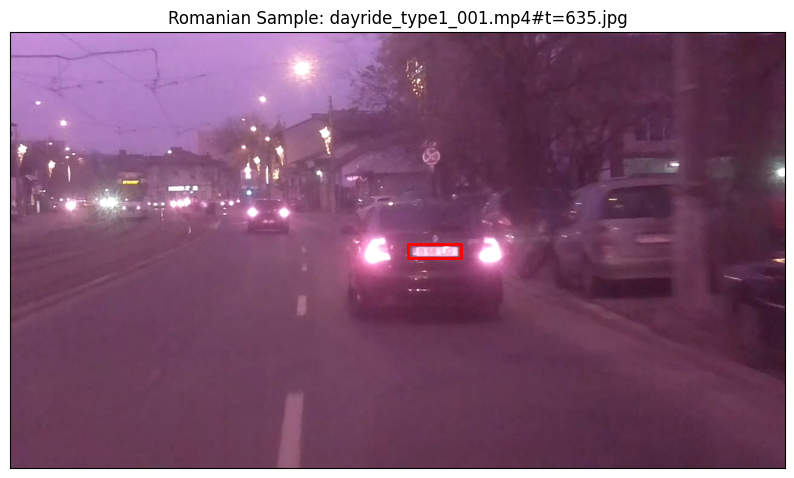

In [ ]:
# --- Minor Modifications to Cell 4 ---
print("--- Testing Romanian Dataset ---")

try:
    # Define paths for Romanian train set
    romanian_train_img_dir = os.path.join(romanian_data_path, 'train', 'images')
    romanian_train_annot_dir = os.path.join(romanian_data_path, 'train', 'annots')

    # List image files and pick a random one
    image_files = [f for f in os.listdir(romanian_train_img_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    if not image_files:
        print("Error: No image files found in Romanian train images directory.")
    else:
        random_image_name = random.choice(image_files)
        image_path = os.path.join(romanian_train_img_dir, random_image_name)
        annot_name = os.path.splitext(random_image_name)[0] + '.xml'
        annot_path = os.path.join(romanian_train_annot_dir, annot_name)

        print(f"Selected Image: {image_path}")
        print(f"Annotation File: {annot_path}")

        # Parse the XML annotation file
        boxes = []
        box_count = 0 # <-- Add counter
        if os.path.exists(annot_path):
            tree = ET.parse(annot_path)
            root = tree.getroot()
            for member in root.findall('object'):
                bndbox = member.find('bndbox')
                if bndbox is not None:
                    xmin = float(bndbox.find('xmin').text)
                    ymin = float(bndbox.find('ymin').text)
                    xmax = float(bndbox.find('xmax').text)
                    ymax = float(bndbox.find('ymax').text)
                    boxes.append((xmin, ymin, xmax, ymax))
                    # print(f"  Found box: ({xmin}, {ymin}, {xmax}, {ymax})") # Optional print
                    box_count += 1 # <-- Increment counter
            if not boxes:
                print("  No <object> tags with <bndbox> found in XML.")
        else:
            print(f"Error: Annotation file not found: {annot_path}")

        print(f"Number of bounding boxes found: {box_count}") # <-- Print count

        # Visualize if boxes were found
        if boxes:
            visualize_image_with_boxes(image_path, boxes, title=f"Romanian Sample: {random_image_name} ({box_count} boxes)")
        elif os.path.exists(image_path):
             print("Visualizing image without boxes as none were found in annotation.")
             visualize_image_with_boxes(image_path, [], title=f"Romanian Sample (No Boxes Found): {random_image_name}")

except Exception as e:
    print(f"An error occurred while testing Romanian dataset: {e}")


--- Testing Spanish Dataset (UC3M-LP JSON Structure) ---
Selected Base ID: 00057
Image Path: ../data/raw/spanish_dataset\train\00057.jpg
JSON Path: ../data/raw/spanish_dataset\train\00057.json
  Found Plate Polygon, Calculated Box: (1159, 2685, 1482, 2801)


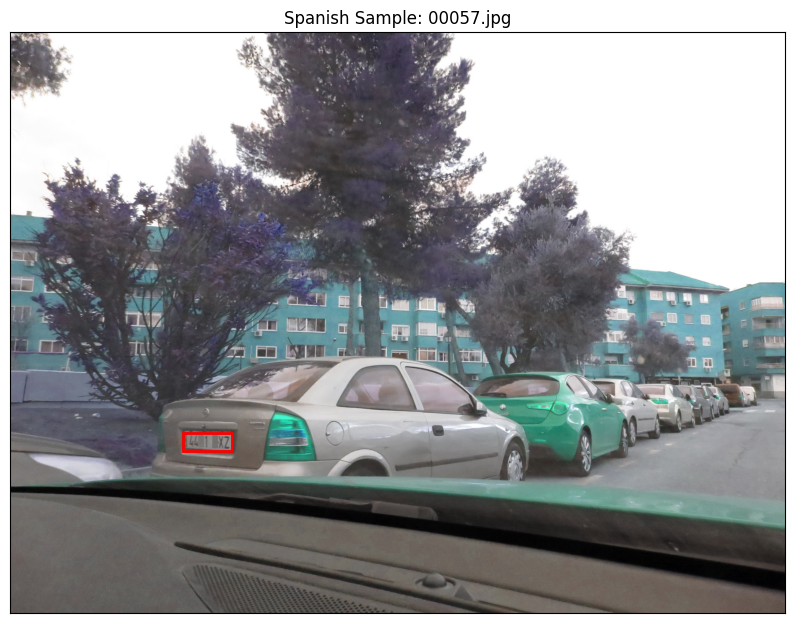

In [7]:
import json # Need the json library
import numpy as np # Need numpy for easy min/max calculations on coordinates

print("\n--- Testing Spanish Dataset (UC3M-LP JSON Structure) ---")

try:
    # Define paths for Spanish train set
    spanish_train_dir = os.path.join(spanish_data_path, 'train')
    train_txt_path = os.path.join(spanish_data_path, 'train.txt')

    # Read the list of base IDs from train.txt
    base_ids = []
    if os.path.exists(train_txt_path):
        # print(f"Reading image IDs from: {train_txt_path}") # Less verbose
        with open(train_txt_path, 'r') as f:
            base_ids = [line.strip() for line in f if line.strip()]
        if not base_ids:
             print("Warning: train.txt is empty or could not be read properly.")
    else:
        print(f"Error: {train_txt_path} not found.")

    if not base_ids:
        print("Error: Could not get any base IDs for Spanish training images.")
    else:
        # Pick a random base ID
        random_id = random.choice(base_ids)
        print(f"Selected Base ID: {random_id}")

        # Construct image and JSON paths
        image_filename = f"{random_id}.jpg" # Assuming jpg extension
        json_filename = f"{random_id}.json"
        image_path = os.path.join(spanish_train_dir, image_filename)
        json_path = os.path.join(spanish_train_dir, json_filename)

        print(f"Image Path: {image_path}")
        print(f"JSON Path: {json_path}")

        # --- Start Revised JSON Parsing ---
        boxes = [] # To store calculated [xmin, ymin, xmax, ymax] boxes
        if os.path.exists(json_path):
            try:
                with open(json_path, 'r') as f:
                    data = json.load(f)

                # Check if the 'lps' key exists and is a list
                if 'lps' in data and isinstance(data['lps'], list):
                    # Iterate through each license plate found in the image
                    for lp_annotation in data['lps']:
                        # Check if 'poly_coord' exists for this plate
                        if 'poly_coord' in lp_annotation and isinstance(lp_annotation['poly_coord'], list):
                            polygon_points = lp_annotation['poly_coord']

                            # Ensure we have points to process
                            if polygon_points:
                                # Use numpy to easily find min/max across points
                                # polygon_points is list of [x, y], numpy array makes slicing easy
                                np_points = np.array(polygon_points)
                                x_coords = np_points[:, 0] # All x values
                                y_coords = np_points[:, 1] # All y values

                                # Calculate axis-aligned bounding box
                                xmin = np.min(x_coords)
                                ymin = np.min(y_coords)
                                xmax = np.max(x_coords)
                                ymax = np.max(y_coords)

                                # Append the calculated box
                                boxes.append((xmin, ymin, xmax, ymax))
                                print(f"  Found Plate Polygon, Calculated Box: ({xmin:.0f}, {ymin:.0f}, {xmax:.0f}, {ymax:.0f})")
                            else:
                                print("  Found 'poly_coord' but it was empty.")
                        else:
                            print("  Skipping LP annotation, missing 'poly_coord' or not a list.")
                else:
                    print("  'lps' key not found or not a list in JSON.")

                if not boxes:
                    print(f"  No valid license plate bounding boxes derived from {json_path}.")

            except json.JSONDecodeError:
                print(f"Error: Could not decode JSON file: {json_path}")
            except Exception as e_parse:
                print(f"Error parsing JSON content or calculating bounds: {e_parse}")
        else:
            print(f"Error: Annotation JSON file not found: {json_path}")
        # --- End Revised JSON Parsing ---

        # Visualize if boxes were found
        if boxes:
            visualize_image_with_boxes(image_path, boxes, title=f"Spanish Sample: {image_filename}")
        elif os.path.exists(image_path):
             print("Visualizing image without boxes as none were found/parsed in annotation.")
             visualize_image_with_boxes(image_path, [], title=f"Spanish Sample (No Boxes Found/Parsed): {image_filename}")
        else:
            print(f"Error: Image file not found: {image_path}")

except Exception as e:
    print(f"An error occurred while testing Spanish dataset: {e}")